In [1]:
# -*- coding: utf-8 -*-

"""
Script:
generator.py
Description:
Just an image captcha generator.
Author:
Jose Miguel Rios Rubio
Creation date:
08/09/2018
Last modified date:
10/06/2019
"""

####################################################################################################

# Modules Imports #

from os import path, walk
from random import randint, choice
from PIL import Image, ImageFont, ImageDraw

####################################################################################################

# Constants #

# Actual constant.py full path
# Path to generate Captchas
GEN_CAPTCHAS_FOLDER = "./captcha_img"

SCRIPT_PATH = path.dirname(path.realpath(GEN_CAPTCHAS_FOLDER))

# Fonts directory and list of used fonts files
FONTS_PATH = SCRIPT_PATH + "/fonts"

# Captcha with noise (turn it on add delay)
ADD_NOISE = False

# Captcha 16:9 resolution sizes (captcha_size_num -> 0 to 12)
CAPTCHA_SIZE = [(256, 144), (426, 240), (640, 360), (768, 432), (800, 450), (848, 480), \
            (960, 540), (1024, 576), (1152, 648), (1280, 720), (1366, 768), (1600, 900), \
            (1920, 1080)]

# Font sizes range for each size
FONT_SIZE_RANGE = [(30, 45), (35, 80), (75, 125), (80, 140), (85, 150), (90, 165), (100, 175), \
               (110, 185), (125, 195), (135, 210), (150, 230), (165, 250), (180, 290)]

# Difficult levels captcha generation values (<lines in full img>, <circles in full img>)
DIFFICULT_LEVELS_VALUES = [(0, 0), (1, 10), (2, 17), (3, 25), (4, 50), (5, 70)]

####################################################################################################

# Image Captcha Generator Class #

class CaptchaGenerator:
    """
    Just and image captcha generator class.
    """

    def __init__(self, captcha_size_num=2):
        """Constructor"""
        # Limit provided captcha size num
        if captcha_size_num < 0:
            captcha_size_num = 0
        elif captcha_size_num >= len(CAPTCHA_SIZE):
            captcha_size_num = len(CAPTCHA_SIZE) - 1
        # Get captcha size
        self.captcha_size = CAPTCHA_SIZE[captcha_size_num]
        # Determine one char image height
        fourth_size = self.captcha_size[0] / 4
        if fourth_size - int(fourth_size) <= 0.5:
            fourth_size = int(fourth_size)
        else:
            fourth_size = int(fourth_size) + 1
        self.one_char_image_size = (fourth_size, fourth_size)
        # Determine font size according to image size
        font_size_min = FONT_SIZE_RANGE[captcha_size_num][0]
        font_size_max = FONT_SIZE_RANGE[captcha_size_num][1]
        self.font_size_range = (font_size_min, font_size_max)
        # Get available Fonts files recursively from fonts directories
        self.l_fonts = []
        for root, directories, files in walk(FONTS_PATH, topdown=True):
            for file in files:
                f_name, f_ext = path.splitext(file)
                if f_ext == ".ttf":
                    self.l_fonts.append(path.join(root, file))
        #print("")
        #print("Detected fonts to be used:")
        #print("---------------------------")
        #for f in self.l_fonts:
        #    print(f)
        #print("")


    def gen_rand_color(self, min_val=0, max_val=255):
        '''Generate a random color.'''
        gen_color = { "color" : "", "R": -1, "G" : -1, "B": -1 }
        gen_color["R"] = randint(min_val, max_val)
        gen_color["G"] = randint(min_val, max_val)
        gen_color["B"] = randint(min_val, max_val)
        gen_color["color"] = "rgb({}, {}, {})".format(str(gen_color["R"]), str(gen_color["G"]), \
                                                    str(gen_color["B"]))
        return gen_color


    def gen_rand_contrast_color(self, from_color):
        '''Generate a random dark or light color for a exact contrast.'''
        dark_level = self.color_dark_level(from_color["R"], from_color["G"], from_color["B"])
        color = "rgb(0, 0, 0)"
        if dark_level == -3:
            color = self.gen_rand_color(0, 42)
        elif dark_level == -2:
            color = self.gen_rand_color(42, 84)
        elif dark_level == -1:
            color = self.gen_rand_color(84, 126)
        elif dark_level == 1:
            color = self.gen_rand_color(126, 168)
        elif dark_level == 2:
            color = self.gen_rand_color(168, 210)
        elif dark_level == 3:
            color = self.gen_rand_color(210, 255)
        return color


    def gen_rand_custom_contrast_color(self, from_color):
        '''Generate a random dark or light color for a custom contrast.'''
        # Get light-dark tonality level of the provided color
        dark_level = self.color_dark_level(from_color["R"], from_color["G"], from_color["B"])
        # If it is a dark color
        if dark_level >= 1:
            # from_color -> (255 - 384) -> (85 - 128)
            color = self.gen_rand_color(148, 255)
            # For high dark
            if dark_level == 3:
                # from_color -> (0 - 128) -> (0 - 42)
                color = self.gen_rand_color(62, 255)
        # If it is a light color
        elif dark_level <= -1:
            # from_color -> (384 - 640) -> (128 - 213)
            color = self.gen_rand_color(0, 108)
            # For high light
            if dark_level == -3:
                # from_color -> (640 - 765) -> (213 - 255)
                color = self.gen_rand_color(0, 193)
        return color


    def color_dark_level(self, r, g, b):
        '''Determine provided color dark tonality level from -3 to 3 (-3 ultra light, \
        -2 mid light, -1 low light, 1 low dark, 2 mid dark, 3 high dark).'''
        dark_level = 0
        if r + g + b < 384:
            dark_level = 1
            if r + g + b < 255:
                dark_level = 2
                if r + g + b < 128:
                    dark_level = 3
            return True
        else:
            dark_level = -1
            if r + g + b > 512:
                dark_level = -2
                if r + g + b > 640:
                    dark_level = -3
        return dark_level


    def color_is_dark(self, r, g, b):
        '''Determine if a provided color has a dark tonality.'''
        # Medium tonality for RGB in 0-255 range -> (255/2)*3 = 384
        if r + g + b < 384:
            return True
        else:
            return False


    def gen_rand_font(self, fonts_list):
        '''Pick a random font file path from provided folder and given possible fonts list.'''
        font_num = randint(0, len(fonts_list)-1)
        font = fonts_list[font_num]
        return font


    def gen_rand_size_font(self, font_path, min_size, max_size):
        '''Generate a random size font PIL object from the given font file path.'''
        font_size = randint(min_size, max_size)
        try:
            font = ImageFont.truetype(font_path, font_size)
            print(font_size)
            # font = ImageFont.truetype(font_path, font_size, encoding='utf8')
            
        except OSError:
            print("Incompatible font for captcha. Using standard arial.ttf")
            font = ImageFont.truetype("arial.ttf", font_size)
            # font = ImageFont.truetype("arial.ttf", font_size, encoding='utf8')
        return font


    def create_image_char(self, size, background, character, char_color, char_pos, char_font):
        '''Create a PIL image object of specified size and color that has the provided character \
        in.'''
        image = Image.new("RGBA", size, background)
        draw = ImageDraw.Draw(image)
        draw.text(char_pos, character, fill=char_color, font=char_font)
        return image


    def add_rand_circle_to_image(self, image, min_size, max_size, circle_color="notSet"):
        '''Draw a random circle to a PIL image.'''
        x = randint(0, image.width)
        y = randint(0, image.height)
        rad = randint(min_size, max_size)
        if circle_color == "notSet":
            circle_color = "rgb({}, {}, {})".format(str(randint(0, 255)), str(randint(0, 255)), \
                                                    str(randint(0, 255)))
        draw = ImageDraw.Draw(image)
        draw.ellipse((x, y, x+rad, y+rad), fill=circle_color, outline=circle_color)


    def add_rand_ellipse_to_image(self, image, w_min, w_max, h_min, h_max, ellipse_color="notSet"):
        '''Draw a random ellipse to a PIL image.'''
        x = randint(0, image.width)
        y = randint(0, image.height)
        w = randint(w_min, w_max)
        h = randint(h_min, h_max)
        if ellipse_color == "notSet":
            ellipse_color = "rgb({}, {}, {})".format(str(randint(0, 255)), str(randint(0, 255)), \
                                                    str(randint(0, 255)))
        draw = ImageDraw.Draw(image)
        draw.ellipse((x, y, x+w, y+h), fill=ellipse_color, outline=ellipse_color)


    def add_rand_line_to_image(self, image, line_width=5, line_color="notSet"):
        '''Draw a random line to a PIL image.'''
        # Get line random start position
        line_x0 = randint(0, image.width)
        line_y0 = randint(0, image.height)
        # If line x0 is in center-to-right
        if line_x0 >= image.width/2:
            # Line x1 from 0 to line_x0 position - 20% of image width
            line_x1 = randint(0, line_x0 - int(0.2*image.width))
        else:
            # Line x1 from line_x0 position + 20% of image width to max image width
            line_x1 = randint(line_x0 + int(0.2*image.width), image.width)
        # If line y0 is in center-to-bottom
        if line_y0 >= image.height/2:
            # Line y1 from 0 to line_y0 position - 20% of image height
            line_y1 = randint(0, line_y0 - int(0.2*image.height))
        else:
            # Line y1 from line_y0 position + 20% of image height to max image height
            line_y1 = randint(line_y0 + int(0.2*image.height), image.height)
        # Generate a rand line color if not provided
        if line_color == "notSet":
            line_color = "rgb({}, {}, {})".format(str(randint(0, 255)), str(randint(0, 255)), \
                                                str(randint(0, 255)))
        # Get image draw interface and draw the line on it
        draw = ImageDraw.Draw(image)
        draw.line((line_x0, line_y0, line_x1, line_y1), fill=line_color, width=line_width)


    def add_rand_horizontal_line_to_image(self, image, line_width=5, line_color="notSet"):
        '''Draw a random line to a PIL image.'''
        # Get line random start position (x between 0 and 20% image width; y with full height range)
        x0 = randint(0, int(0.2*image.width))
        y0 = randint(0, image.height)
        # Get line end position (x1 symetric to x0; y random from y0 to image height)
        x1 = image.width - x0
        y1 = randint(y0, image.height)
        # Generate a rand line color if not provided
        if line_color == "notSet":
            line_color = "rgb({}, {}, {})".format(str(randint(0, 255)), str(randint(0, 255)), \
                                                str(randint(0, 255)))
        # Get image draw interface and draw the line on it
        draw = ImageDraw.Draw(image)
        draw.line((x0, y0, x1, y1), fill=line_color, width=5)


    def add_rand_noise_to_image(self, image, num_pixels):
        '''Add noise pixels to a PIL image.'''
        draw = ImageDraw.Draw(image)
        for _ in range(0, num_pixels):
            pixel_color = "rgb({}, {}, {})".format(str(randint(0, 255)), str(randint(0, 255)), \
                                                   str(randint(0, 255)))
            draw.point((randint(0, image.width), randint(0, image.height)), pixel_color)


    def images_join_horizontal(self, list_images):
        '''Horizontally join PIL images from list provided and create a single image from them.'''
        image = Image.new("RGB", (self.one_char_image_size[0]*len(list_images), \
                                  self.one_char_image_size[1]))
        x_offset = 0
        for img in list_images:
            image.paste(img, (x_offset, 0))
            x_offset += img.size[0]
        return image


    def gen_captcha_char_image(self, character, image_size, lines=2, background_color=False,
            rotation_limits=(-44, 44)):
        '''Generate an one-char image with a random positioned-rotated character.'''
        # If not background color provided, generate a random one
        if not background_color:
            background_color = self.gen_rand_color()
        rand_color = self.gen_rand_custom_contrast_color(background_color)
        character_color = rand_color["color"]
        # character_pos = (int(image_size[0]/16), randint(0, int(image_size[0]/16)))
        character_pos = (0, 0)
        
        # Pick a random font with a random size, from the provided list
        rand_font_path = self.gen_rand_font(self.l_fonts)
        print(rand_font_path)
        # rand_font_path = 'C:/Users/Jay/Desktop/project/fonts/GoogleFonts/ofl/bonbon\Bonbon-Regular.ttf'
        character_font = self.gen_rand_size_font(rand_font_path, self.font_size_range[0], \
                self.font_size_range[1])
        
        # Create an image of specified size, background color and character
        image = self.create_image_char(image_size, background_color["color"], character, \
                character_color, character_pos, character_font)
        print(character_pos)
        # Random rotate the created image between -55? and +55?
        image = image.rotate(randint(rotation_limits[0], rotation_limits[1]), \
                fillcolor=background_color["color"])
        # Add some random lines to image
        for _ in range(0, lines):
            self.add_rand_line_to_image(image, 3, character_color)
        # Add noise pixels to the image
        if ADD_NOISE:
            self.add_rand_noise_to_image(image, 200)
        # Return the generated image
        generated_captcha = {"image": image, "character": character}
        return generated_captcha

    ################################################################################################

    def gen_captcha_image(self, input_text=None, difficult_level=2, chars_mode="nums", multicolor=False, \
            margin=True):
        '''Generate an image captcha.'''
        # Limit difficult level argument if out of expected range
        if difficult_level > 5:
            print("INFO: Captcha generation for a higher difficult level than expected.")
            print("      Using difficult level 5.")
            print("")
            difficult_level = 5
        # If invalid chars mode provided, use numbers
        chars_mode = chars_mode.lower()
        if (chars_mode != "nums") and (chars_mode != "hex") and (chars_mode != "ascii") and (chars_mode !="custom"):
            chars_mode = "nums"
        # Determine one char image height
        fourth_size = self.captcha_size[0] / len(input_text)
        
        print(fourth_size)
        
        if fourth_size - int(fourth_size) <= 0.5:
            fourth_size = int(fourth_size) - 1
        else:
            fourth_size = int(fourth_size) + 1
        self.one_char_image_size = (fourth_size, fourth_size)
                
        # Generate a RGB background color if the multicolor is disabled
        if not multicolor:
            image_background = self.gen_rand_color()
            
            print(image_background)
            
        # Generate 4 one-character images with a random char color in contrast to the generated
        # background, a random font and font size, and random position-rotation
        one_char_images = []
        image_characters = ""
        if chars_mode == "custom":
            print(chars_mode)
            for i in range(len(input_text)):
                character = input_text[i]
                # Generate a random character, a random character color in contrast to background
                # and a random position for it
                if multicolor:
                    image_background = self.gen_rand_color()
                captcha = self.gen_captcha_char_image(character, self.one_char_image_size, 1, \
                        image_background)
                image = captcha["image"]
                image_characters = image_characters + captcha["character"]
                # Add the generated image to the list
                one_char_images.append(image)
                # image.save("./captcha_img/{0}.png".format(character + str(i)), "png")
        else:
            for _ in range(0,4):
                # Generate a random character
                if chars_mode == "nums":
                    character = str(randint(0, 9))
                elif chars_mode == "hex":
                    characters_availables = "ABCDEF0123456789"
                    character = choice(characters_availables)
                elif chars_mode == "ascii":
                    characters_availables = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
                    character = choice(characters_availables)
                # Generate a RGB background color for each iteration if multicolor enabled
                if multicolor:
                    image_background = self.gen_rand_color()
                # Generate a random character, a random character color in contrast to background
                # and a random position for it
                captcha = self.gen_captcha_char_image(character, self.one_char_image_size, 2, \
                        image_background)
                image = captcha["image"]
                image_characters = image_characters + captcha["character"]
                # Add the generated image to the list
                one_char_images.append(image)
                
        # Join the 4 characters images into one
        image = self.images_join_horizontal(one_char_images)
        # Add one horizontal random line to full image
        for _ in range(0, DIFFICULT_LEVELS_VALUES[difficult_level][0]):
            self.add_rand_horizontal_line_to_image(image, randint(1, 5))
        # Add some random circles to the image
        for _ in range(0, DIFFICULT_LEVELS_VALUES[difficult_level][1]):
            self.add_rand_circle_to_image(image, int(0.05*self.one_char_image_size[0]), \
                                          int(0.15*self.one_char_image_size[1]))
        # # Add horizontal margins
        # if margin:
        #     new_image = Image.new('RGBA', self.captcha_size, "rgb(0, 0, 0)")
        #     new_image.paste(image, (0, int((self.captcha_size[1]/2) - (image.height/2))))
        #     image = new_image
            
        generated_captcha = {"image": image, "characters": image_characters}
        return generated_captcha

c:\users\jay\anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  from ipykernel import kernelapp as app
c:\users\jay\anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


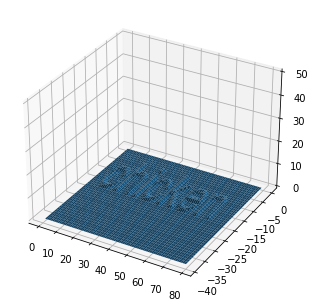

In [2]:
import numpy
import pylab
from PIL import Image, ImageDraw, ImageFont
import mpl_toolkits.mplot3d.axes3d as axes3d

img = Image.new('L', (80, 40), 255)
drw = ImageDraw.Draw(img)
font = ImageFont.truetype('arial.ttf', 20)
drw.text((5, 1), 'chicken', font = font)

X, Y = numpy.meshgrid(range(80), range(40))
Z = 1 - numpy.asarray(img) / 255

fig = pylab.figure()
ax = axes3d.Axes3D(fig)
ax.plot_surface(X, -Y, Z, rstride = 1, cstride = 1)
ax.set_zlim((0, 50))

fig.show()

c:\users\jay\anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


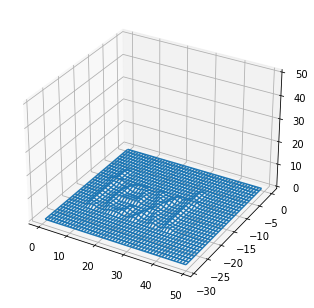

In [3]:
import numpy, pylab
from PIL import Image, ImageDraw, ImageFont
import mpl_toolkits.mplot3d.axes3d as axes3d

sz = (50,30)

img = Image.new('L', sz, 255)
drw = ImageDraw.Draw(img)
font = ImageFont.truetype("arial.ttf", 20)

drw.text((5,3), 'text', font=font)
img.save('./test.png')

X , Y = numpy.meshgrid(range(sz[0]),range(sz[1]))
Z = 1-numpy.asarray(img)/255

fig = pylab.figure()
ax = axes3d.Axes3D(fig)
ax.plot_wireframe(X, -Y, Z, rstride=1, cstride=1)
ax.set_zlim((0,50))
fig.savefig('./test2.png')

c:\users\jay\anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


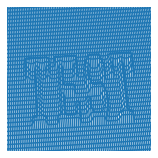

In [4]:
from random import uniform, shuffle
from PIL import ImageFont, Image, ImageDraw
import numpy, pylab
from mpl_toolkits.mplot3d import Axes3D

def makeImage(text, width=400, height=200, angle=None):
    angle = angle if angle != None else uniform(-20, 20)
    try:
        font = ImageFont.truetype('C:/Users/Jay/Desktop/project/fonts/GoogleFonts/ofl/graduate\Graduate-Regular.ttf', 25)
    except IOError:
        raise IOError(
            'Font file doesn\'t exist. Please set `fontPath` correctly.')
    txtW, txtH = font.getsize(text)
    img = Image.new('L', (txtW * 3, txtH * 3), 255)
    drw = ImageDraw.Draw(img)
    drw.text((txtW, txtH), text, font=font)

    fig = pylab.figure(figsize=(width/100.0, height/100.0))
    ax = Axes3D(fig)
    X, Y = numpy.meshgrid(range(img.size[0]), range(img.size[1]))
    Z = 1 - numpy.asarray(img) / 255
    ax.plot_wireframe(X, -Y, Z, rstride=1, cstride=1)
    ax.set_zlim((-3, 3))
    ax.set_xlim((txtW * 1.1, txtW * 1.9))
    ax.set_ylim((-txtH * 1.9, -txtH * 1.1))
    ax.set_axis_off()
    ax.view_init(elev=60, azim=-90 + angle)
    
img = makeImage('test', width=512)

In [11]:
GEN_CAPTCHAS_FOLDER = "./captcha_img"

SCRIPT_PATH = path.dirname(path.realpath(GEN_CAPTCHAS_FOLDER))

# Fonts directory and list of used fonts files
FONTS_PATH = SCRIPT_PATH + "/fonts"

# Captcha with noise (turn it on add delay)
ADD_NOISE = False

# Captcha 16:9 resolution sizes (captcha_size_num -> 0 to 12)
CAPTCHA_SIZE = [(256, 144), (426, 240), (640, 360), (768, 432), (800, 450), (848, 480), \
            (960, 540), (1024, 576), (1152, 648), (1280, 720), (1366, 768), (1600, 900), \
            (1920, 1080)]

# Font sizes range for each size
FONT_SIZE_RANGE = [(30, 45), (35, 80), (75, 125), (80, 140), (85, 150), (90, 165), (100, 175), \
               (110, 185), (125, 195), (135, 210), (150, 230), (165, 250), (180, 290)]

# Difficult levels captcha generation values (<lines in full img>, <circles in full img>)
DIFFICULT_LEVELS_VALUES = [(0, 0), (1, 10), (2, 17), (3, 25), (4, 50), (5, 70)]

l_fonts = []
for root, directories, files in walk(FONTS_PATH, topdown=True):
    for file in files:
        f_name, f_ext = path.splitext(file)
        if f_ext == ".ttf":
            l_fonts.append(path.join(root, file))


def gen_rand_font(fonts_list):
    '''Pick a random font file path from provided folder and given possible fonts list.'''
    font_num = randint(0, len(fonts_list)-1)
    font = fonts_list[font_num]
    return font

font = gen_rand_font(l_fonts)
font

'C:\\Users\\Jay\\Desktop\\project/fonts\\GoogleFonts\\ofl\\combo\\Combo-Regular.ttf'

In [12]:
from captcha.image import ImageCaptcha
from PIL import ImageFont

# Create an image instance of the gicen size
image = ImageCaptcha(width=280, height=90, fonts=font)
print(image)

capt_text = 'test'
# generate the image of the given text
data = image.generate(capt_text)

OSError: cannot open resource

In [ ]:
data

In [ ]:
import os
file_path = './static/images/img_captcha/'
file_names = os.listdir(file_path)
file_names

['1인1닭_ 치킨덕후_하루 기준치 당·나트륨 절반 섭취한 셈 _ 중앙일보.jpg',
 'KB경영연구소 _치킨집 현황 및 시장 여건 분석_ 보고서 2019년_yythkg.jpg',
 '맛있는 치킨의 유혹.. 뜻밖의 건강효과 5가지 - 코메디닷컴.jpg',
 '양념 치킨 - 장독대.jpg',
 '오늘 저녁 치킨_ _당모치__ 치킨 브랜드 추천 5가지.png',
 '우리나라 치킨 프랜차이즈 계(鷄)보 _ rereco.jpg',
 '정진홍의 컬처 엔지니어링] 대한민국 울린 _치킨 한 접시_ - 조선.jpg',
 '주)한울.png',
 '치킨 (1).png',
 '치킨 (한국 음식) - 위키백과_ 우리 모두의 백과사전.jpg',
 '치킨 - 나무위키.jpg',
 '치킨 메뉴.png',
 '치킨 브랜드 선호도_ 교촌치킨 독주 속_ 2위 경쟁 치열 -_yyt.jpg',
 '치킨.png',
 '치킨만 팔다간 망한다_…`치느님` 외도 나선 까닭은 - 매일경제.jpg',
 '치킨먹방의 표본_│치밥은기본이지_(후라이드치킨_양념치킨먹방)Mukbang Eatingshow [Fried Chicken_yythk.jpg',
 '치킨집 배달 주문 4명 중 3명 앱 이용…만족도 1위 브랜드는_yy.jpg',
 '치킨파티 (1).jpg',
 '치킨파티.jpg',
 '치킨히어로.png',
 '쿠캣마켓.jpg',
 '프라이드 치킨 - 나무위키.png',
 '한국식 치킨은 해외서도 통했다_ 김치·비빔밥 밀고 선호 1위 _ 중.jpg',
 '호불호 끝판왕_ 멕시카나 _달콤라떼치킨_ 치킨 출시.jpg',
 '호식이두마리치킨_ 15일부터 _치킨치킨송_ TV광고 시작 _ 호식이두마리치킨.jpg']

In [ ]:
i = 1
for name in file_names:
    src = os.path.join(file_path, name)
    dst = str(i) + '.png'
    dst = os.path.join(file_path, dst)
    os.rename(src, dst)
    i += 1